# Домашняя работа 3. Коллаборативная фильтрация

Поэкспериментировать с ALS (grid-search)

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline

from pathlib import Path
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from itertools import product

In [2]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [3]:
def recall(recommended_list, bought_list):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    flags = np.isin(bought_list, recommended_list)
    
    recall = flags.sum() / len(bought_list)
    
    return recall

def recall_at_k(recommended_list, bought_list, k=5):
    return recall(recommended_list[:k], bought_list)

In [13]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)]
    return res

In [19]:
def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [42]:
def grid_search(result, factors, iterations, regularizations=0.001):
    metrics_grig_search = {}
    for i in range(len(list(product(factors,iterations)))):
        model = AlternatingLeastSquares(factors=list(product(factors,iterations))[i][0], 
                                regularization=regularizations,
                                iterations=list(product(factors,iterations))[i][1], 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        result[f'als_factors={list(product(factors,iterations))[i][0]},_iter={list(product(factors,iterations))[i][1]}'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        
        metrics_grig_search[f'als_factors={list(product(factors,iterations))[i][0]},_iter={list(product(factors,iterations))[i][1]}'] = result.apply(lambda row: precision_at_k(row[f'als_factors={list(product(factors,iterations))[i][0]},_iter={list(product(factors,iterations))[i][1]}'], row['actual']), axis=1).mean()
    
    return result, metrics_grig_search

In [45]:
def grid_search_reg(result, regularizations):
    metrics_grig_search_reg = {}
    for i in range(len(regularizations)):
        
        model = AlternatingLeastSquares(factors=200, 
                                regularization=regularizations[i],
                                iterations=20, 
                                calculate_training_loss=True, 
                                num_threads=4)
        
        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        result[f'als_reg={regularizations[i]}'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        
        metrics_grig_search_reg[f'als_reg={regularizations[i]}'] = result.apply(lambda row: precision_at_k(row[f'als_reg={regularizations[i]}'], row['actual']), axis=1).mean()
    
    return result, metrics_grig_search_reg

In [4]:
DATA_PATH = Path('C:/Users/Данила/Documents/Data science/RecSys/webinar_3')

In [5]:
data = pd.read_csv(DATA_PATH/'retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [6]:
item_features = pd.read_csv(DATA_PATH/'product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [7]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [8]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [9]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

### Построение модели ALS

In [10]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [12]:
%%time

model = AlternatingLeastSquares(factors=100,  # Нужно подбирать
                                regularization=0.001,
                                iterations=15,
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=[itemid_to_id[999999]], 
                        filter_items=None, 
                        recalculate_user=False)


Wall time: 2.82 s


In [14]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
als_metric = result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
als_metric

Wall time: 40.9 s


0.1794319294808986

In [15]:
result.head(5)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 979707, 832678, 995242, 5569374]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 5568378, 910032, 822407, 951590]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1023720, 1051516, 923746, 1007195, 878996]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1058997, 1126899, 938700, 1082185, 1133018]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1068719, 1053690, 938700, 1004906, 965766]"


### Embeddings

In [16]:
model.item_factors.shape

(5001, 100)

In [17]:
model.user_factors.shape

(2499, 100)

Можно очень быстро посчитать предсказания, перемножив эти 2 матрицы

In [18]:
%time

fast_recs = model.user_factors @ model.item_factors.T 
fast_recs.shape

Wall time: 0 ns


(2499, 5001)

### Визуализация результатов рекоммендаций

In [20]:
model.item_factors.shape

(5001, 100)

In [21]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

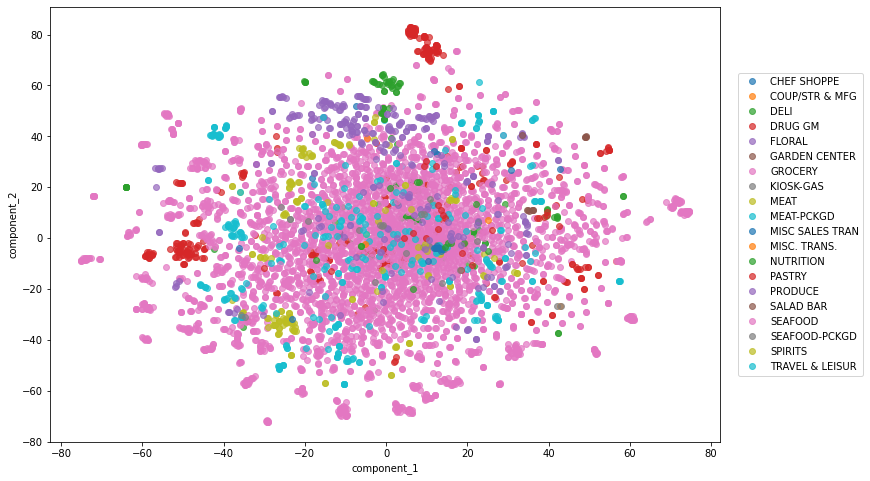

Wall time: 34.6 s


In [22]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Нарисуем все, кроме GROCERY

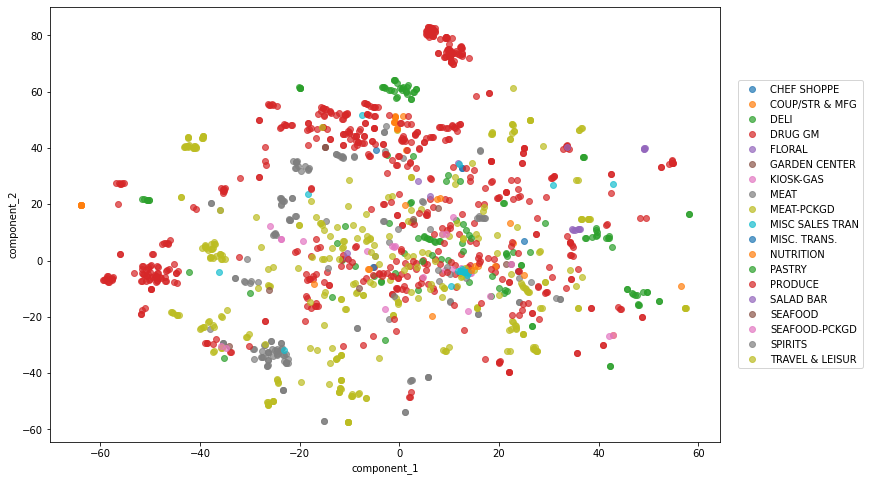

In [23]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

Нарисуем несколько конкретных категорий

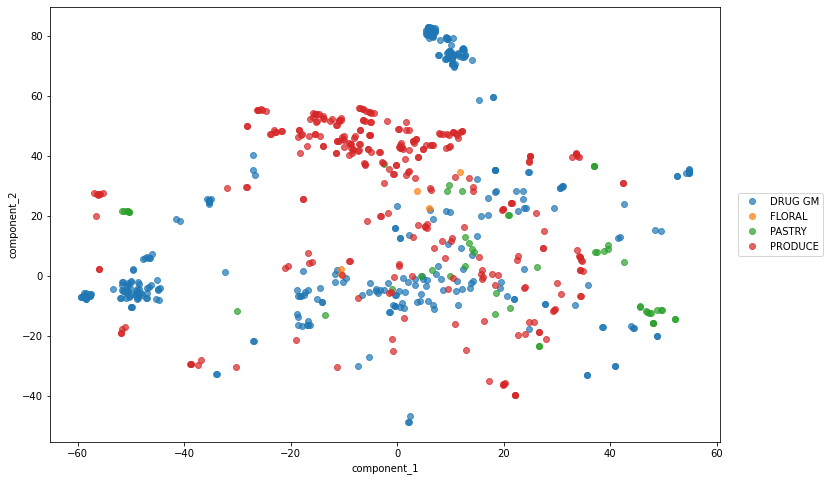

In [24]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

**Результат средний**:
- Модель выучила похожесть только небольшой части товаров

In [25]:
item_emb_tsne.head(2)

,component_1,component_2,category
0,13.138408,-4.081443,MISC SALES TRAN
1,12.426700,-2.564847,KIOSK-GAS


### Рекоммендации похожих товаров

recommend_all делает перемножение, но еще и сортирует и выбирает топ-N

In [26]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=csr_matrix(user_item_matrix).tocsr(),
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)


Wall time: 23.7 s


In [27]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

*Посмотрите также / Похожие товары*

In [28]:
model.similar_items(itemid_to_id[202291], N=5)

[(0, 1.0),
 (4, 0.9828797),
 (4256, 0.98251235),
 (4106, 0.9824299),
 (4305, 0.980678)]

In [29]:
[id_to_itemid[rec[0]] for rec in 
                    model.similar_items(itemid_to_id[202291], N=5)] 

[202291, 545926, 5747233, 1388206, 6410464]

*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [30]:
model.similar_users(userid_to_id[10], N=5)

[(9, 1.0),
 (790, 0.9772778),
 (239, 0.975021),
 (354, 0.9748146),
 (1627, 0.97306097)]

### TF-IDF взвешивание

In [31]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [32]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

tfidf_metric = result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()
tfidf_metric


Wall time: 36 s


0.188932419196863

### BM25 взвешивание

In [33]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [37]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

bm25_metric = result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()
bm25_metric


Wall time: 42.2 s


0.2255631733594484

In [38]:
metrics_weight = pd.DataFrame({'ALS': [als_metric], 'ALS_tfidf': [tfidf_metric],'ALS_bm25': [bm25_metric]}, index = {'precision@5'})
metrics_weight

,ALS,ALS_tfidf,ALS_bm25
precision@5,0.179432,0.188932,0.225563


In [44]:
result.to_csv(DATA_PATH / 'predictions_cf.csv', index=False)  # cf - collaborative filtering

## Поиск оптимальных параметров

**factors и iterations**

In [39]:
# создаем и взвешиваем матрицу предпочтений
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix = bm25_weight(user_item_matrix.T).T 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [43]:
#сетка с параметрами
factors=[100, 150, 200, 250]
iterations=[20,50, 100]

result, metrics_grig_search = grid_search(result, factors, iterations, regularizations=0.001)

In [46]:
metrics_grig_search

{'als_factors=100,_iter=20': 0.22086190009794007,
 'als_factors=100,_iter=50': 0.22193927522036924,
 'als_factors=100,_iter=100': 0.22135161606268094,
 'als_factors=150,_iter=20': 0.229382957884424,
 'als_factors=150,_iter=50': 0.2292850146914762,
 'als_factors=150,_iter=100': 0.2338883447600362,
 'als_factors=200,_iter=20': 0.23271302644465877,
 'als_factors=200,_iter=50': 0.2277179236043066,
 'als_factors=200,_iter=100': 0.22918707149852785,
 'als_factors=250,_iter=20': 0.224094025465227,
 'als_factors=250,_iter=50': 0.2235063663075384,
 'als_factors=250,_iter=100': 0.2220372184133175}

In [47]:
#поиск оптимальных параметров
max_val = max(metrics_grig_search.values())
opt_params = {k:v for k, v in metrics_grig_search.items() if v == max_val}

print('Оптимальные параметры: ')
opt_params

Оптимальные параметры: 


{'als_factors=150,_iter=100': 0.2338883447600362}

In [48]:
best_model = AlternatingLeastSquares(factors=150, 
                                regularization=0.001,
                                iterations=100, 
                                calculate_training_loss=True, 
                                num_threads=4)

**Regularizations**

In [49]:
#сетка с параметрами
regularizations = [0.01, 0.001, 0.0001]
result, metrics_grig_search_reg = grid_search_reg(result, regularizations)

In [50]:
metrics_grig_search_reg

{'als_reg=0.01': 0.23300685602350324,
 'als_reg=0.001': 0.2285014691478913,
 'als_reg=0.0001': 0.23183153770812623}

In [51]:
#поиск оптимальных параметров
max_val_reg = max(metrics_grig_search_reg.values())
opt_params_reg = {k:v for k, v in metrics_grig_search_reg.items() if v == max_val_reg}

print('Оптимальные параметры: ')
opt_params_reg

Оптимальные параметры: 


{'als_reg=0.01': 0.23300685602350324}

In [52]:
best_model = AlternatingLeastSquares(factors=150, 
                                regularization=0.01,
                                iterations=100, 
                                calculate_training_loss=True, 
                                num_threads=4)